# 0. Preliminaries

## Drive integration
You have to connect to your drive each time you start the execution of a colab notebook. It supposes that you have performed the steps provided in [Lab 1](https://colab.research.google.com/github/roboticsmind/2021-AI-Industry-Labs/blob/master/1_DiscoveringTheSHLDataset.ipynb).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/ml-iot/2021-AI-Industry-Labs/

## Pull latest updates from the central repository
When you run the following cell, if something is pulled from the repository (i.e. you have a message other than "Already up to date."), you have to restart the execution environment using "**Ctrl+M .**" and re-run the previous cells. Otherwise, just proceed with the remaining cells.

In [ ]:
!git pull

## Create (or re-create) a sample
It is safer, even if this was already done during Lab 1

In [ ]:
!rm -r generated/sample
!rm -r generated/0.1
!mkdir -p generated/sample/train/Torso
!cp -r generated/tmp/validation/ generated/sample/validation

In [ ]:
import sample

idxs = sample.build_sample(student_id=?????)  # put here your student id
sample.save_index(idxs, 'generated/sample/2021-01-sample.pickle')

In [ ]:
# load data and visualize its format
from dataset import DataReader

# when run for the first time, this may take a while!
train = DataReader(what='train', train_frames=?????)  # !!! Beware !!! you have to replace ?????? with the size of your sample as it is shown when you run the previous cell !!!
valid = DataReader(what='validation')



---

## Check if the Data Was Loaded Correctly

**Ex. 1** take the time to explore the data structure that contains the SHL data and its contents: number of train and test points, their array size, etc.
Take also a look at the labels.
You can use `len()` and `arrrayName.shape()`.

In [ ]:
train.X['Torso']['Acc_x'][-1]



---


# 1. Building our First Activity Recognition Models

Building a neural network in general requires configuring the layers of the model, then compiling the model.  The basic building block of a neural network is thelayer.   Layers  extract  representations  from  the  data  fed  into  them.   Hopefully,  these  representations  are  meaningful  for  the  problem  at  hand.   Most  of deep learning consists of chaining together simple layers.  Most layers, such as `tf.keras.layers.Dense` or `tf.keras.layers.Conv1d`, have parameters that are learned during training.
The network that we will construct during this lab is depicted in the following figure.
<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/106061343-8c2dd500-60f5-11eb-8226-ca703437ffcb.png" height="600"/>
</p>


The **first** part of the network (starting from the bottom) consists of input layers `tf.keras.Input` with shape 500 which corresponds to the size of the examples from the SHL dataset.
Note that we will start with a simple model that takes as input only a single channel (Acc_x) and later on we will leverage the remaining channels and modalities (Gyr, Mag) via different sensor fusion schemes.

<!--
<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/103903120-c78f4200-50fb-11eb-8a38-8f50f790c6fe.png" height="200px"/>
</p>
-->


The **second** part of the network consists of a sequence of two `tf.keras.layers.Dense` layers.   These  are  densely  connected,  or  fully  connected, neural layers.  The first Dense layer has 128 nodes (or neurons).  The second (and last) layer is a 8-node softmax layer that returns an array of 8 probability scores that sum to 1.  Each node contains a score that indicates the probability that the current example belongs to one of the 8 classes.

In this exercise, we don't explain the reasons of defining a neural network with this architecture. So, to define  a  network  compatible  with  our  data,  we  should define an input layer with the same size as the input data and an output corresponding the output data.

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/103903117-c5c57e80-50fb-11eb-986a-e3de1b32b051.png" height="200px"/>
</p>


**Side notes about the 1-Dimension Convolution**

Here you can see an illustration of the process of convolution between two signals (top) along with its result (bottom).

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/104822951-b4d8e380-5846-11eb-9c16-dc7b2fbcd610.gif" height="200px">
</p>

More formally, given two functions f and g, the convolution can be written as follows. 
Check out [this](https://fr.wikipedia.org/wiki/Produit_de_convolution) entry in wikipedia to find out more.
<p align="center">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/09e0e66216b29a0ccd3d60a6e0f9aba3ce6fb4b2">
</p>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

**Ex. 2 (code provided)** Build the network as shown above.

Note that we use a single channel which is `Acc_x` (the x dimension of accelerometer) of the Torso. So we first specify these.

We will be using `tf.keras.Input` to handle the sensory input.

We will be using (for now, a single) `tf.keras.Conv1D` to extract useful features from the sensory input. These are followed by a `tf.keras.MaxPooling1D` layer used to select the most prominent filter responses in a feature map. (As mentioned, it is not important to understand every aspect of the network now but if you are interested you can check out [this](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks) introduction to pooling layers for convolutional neural networks).

we will be using `tf.keras.Dense` to perform the categorization of the input signals into their corresponding class.


If you have any doubt, please check out the documentation of the layers by hovering on it in the code or by following these links:
* [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
* [MaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool1D)
* [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)

In [ ]:
position='Torso'
channel='Acc_x'

In [ ]:
# 3D tensor with shape: (batch_size, steps, input_dim)
ts = keras.Input(shape=(500,), name=position+'_'+channel)
x = keras.layers.Reshape((500, 1))(ts)

x = keras.layers.Conv1D(
    filters=32,
    kernel_size=7,
    strides=2,
    padding='valid',
    activation='relu',
    input_shape=(None, 500, 1),
    name=position+'/'+channel+'/Conv1d/layer_0')(x)
x = keras.layers.MaxPooling1D()(x)

x = keras.layers.GlobalMaxPooling1D()(x)

In [ ]:
x = keras.layers.Dense(
    units=128,
    activation='relu',
    name='Dense/layer_1')(x)

In [ ]:
class_output = keras.layers.Dense(
    units=8,  # corresponds to the number of classes to be predicted
    activation='softmax',
    name='class_output')(x)

In [ ]:
model = keras.Model(inputs=ts, outputs=class_output)

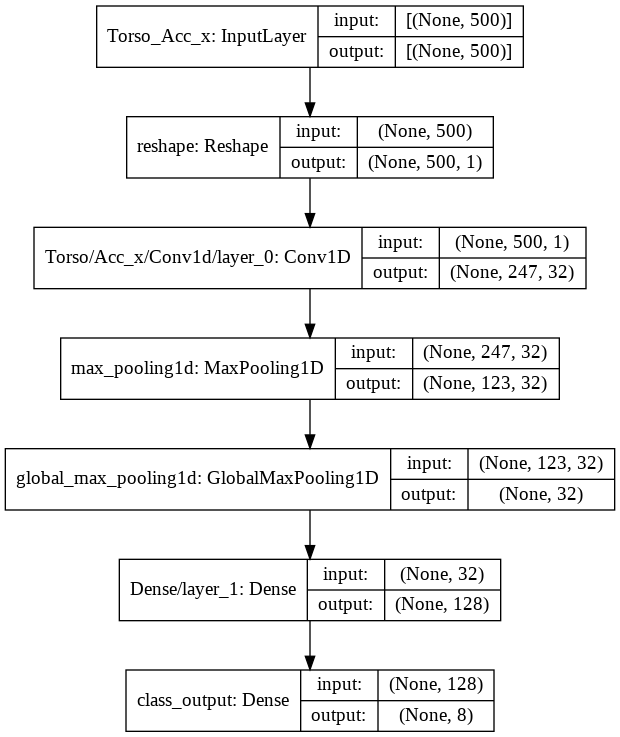

In [ ]:
keras.utils.plot_model(model, 'first_model.png', show_shapes=True)

**Ex. 3 (code provided)** Before the model is ready for training,  it needs a few more settings. These are added during the model's compile step (We will explain the following parts in details during the future sections.  Use them here as an example, because it is necessary for NN trainings):
- Loss function: This measures how accurate the model is during training. You  want  to  minimize  this  function  to  ”steer”  the  model  in  the  right direction;
- Optimizer: This is how the model is updated based on the data it sees and its loss function;
- Metrics: Used  to  monitor  the  training  and  testing  steps.   The  following example uses accuracy, the fraction of the images that are correctly classified.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True),
    loss=[keras.losses.CategoricalCrossentropy(from_logits=True)],
    metrics=['acc'])

In [ ]:
model.summary()

**Ex. 4 (code provided)** Format the data according to the naming convention used to define the Input layers (i.e. `ts = keras.Input(shape=(500,), name=position+'_'+channel)`). This will be re-used later when we will leverage the remaining channels and modalities.

In [ ]:
def format_data(train, valid):

    train_dict = {}
    valid_dict = {}
    for chan in [channel]:
        train_dict[position + '_' + channel] = train.X[position][channel]
        valid_dict[position + '_' + channel] = valid.X[position][channel]

    train_labels = train.y[:, 0] - 1  # classes should be from 0 to num_classes-1
    valid_labels = valid.y[:, 0] - 1

    return train_dict, train_labels, valid_dict, valid_labels

In [ ]:
train_dict, train_labels, valid_dict, valid_labels = format_data(train, valid)

**Ex. 5 (code provided)** Training the neural network model requires the following steps:
- Feed the training data to the model.  In this example, the training data isin the train images and trainlabels arrays.
- The model learns to associate images and labels.
- You ask the model to make predictions about a test set, in this example,the test images array.  Verify that the predictions match the labels fromthe test labels array.

In [ ]:
history = model.fit(
    train_dict,
    keras.utils.to_categorical(train_labels, num_classes=8),
    batch_size=512,
    epochs=50,
    shuffle=True
)

**Ex. 6** Plot the evolution of the training loss as a function of the training epochs. Hint: the loss can be found in the dictionnary `history.history[????]` returned by `model.fit()` above.

In [ ]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.????(????)

**Ex. 7 (code provided)** Check out the distribution of the model's weights.

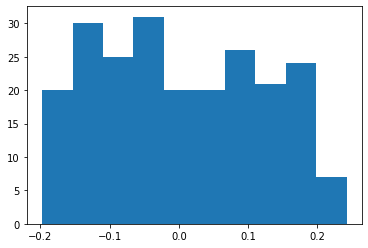

In [ ]:
model.weights

weights, bias = model.get_layer(position+'/'+channel+'/Conv1d/layer_0').get_weights()
plt.hist(tf.keras.backend.eval(weights).ravel())
plt.show()

**Ex. 8** If you want to visualize the evolution of the weights distribution before and after training, you have to save a version of the model we defined above (in a new variable) before training and compare it to the weights of the trained model after training. Plot the two distributions (before and after) in the same figure.

In [ ]:
# plot weights distribution before and after training
model_initial = keras.Model(inputs=ts, outputs=class_output)  # create a new model with randomly initialized weights
model_initial.weigths

weights, bias = model_initial.get_layer(position+'/'+channel+'/Conv1d/layer_0').get_weights()
plt.hist(tf.keras.backend.eval(weights).ravel())
plt.show()

**Ex. 9** The model predicts a label for each image in the validation set.
Check the shape of the predictions. Print the first, second  and  third  element  of  the  predicted  test  sets.   You  can  see  that  each element contains 8 values indicating a probability of each label.  Choose the maximum one using `np.argmax()` function.  Compare the predicted label of the first three elements with their predicted labels.  How many are correct?

In [ ]:
# perform prediction on the entire validation set
# validation examples are in valid_dict

In [ ]:
# print the shape of the predictions returned by the model


In [ ]:
# compare the predicted label of the first three elements with their predicted labels
# labels corresponding to the examples inside valid_dict can be found in valid_labels

**Ex. 10** Grab a single element from the test set such as `valid_dict['Torso_Acc_x'][5]`.  Send it to the `model.predict()` and check what will happen.  Why?  Correct it.  (hint:  you can use `expand_dims()` from the `numpy` library).

In [ ]:
# prediction of a single example


### Visualizing the predictions

**Ex. 11** Using the `plotly`-based code you saw during the first lab, we want you to write code that can display the predictions along with the sensory signals. This can provide interesting insights about the behavior of your machine learning model.
You should get something like what is depicted in the following figure but you can design alternative ways for visualizing the predictions which can help you analyze the behavior of your model:
<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/106063587-b5039980-60f8-11eb-9a9f-e4306a035de6.png" height="500px"/>
</p>

In this figure, the examples that are correctly classified are colored in green and those incorrectly classified are colored in red.
Add also a text that will appear when we hover above an example and display the true label of the example and the one predicted by your model.

In [ ]:
# display sensory signals along with model's predictions
from IPython.display import HTML
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go


fig = go.Figure()
for i in range(100):
    # select an example
    # get a its prediction
    fig.add_trace(
        go.Scatter(
            # parameters to go.Scatter
        )
    )
HTML(fig.to_html())

### Playing with the Network's Hyperparameters

**Ex. 12** Keep the input and output sizes and try to change the hyperparameters of your model, i.e. `kernel_size`, `filters`, `stride`, etc. in **Ex. 2** and observe their effects of your changes on the performances. Save your different runs and try to analyze and document your observations.

**Exemple d'Analyse**
On observe après l'ajout d'une couche que les preformances sur les données d'entrainement augmentent mais celle sur les données de validation se dégradent.
L'hypothèse la plus probable pour expliquer cette observation est que le modèle est sur-paramétré et qu'il se sépcialise sur les données d'entrainement.

### Stacking additional 1d convolution layers

**Ex. 13** till now, we used networks containing a single `tf.keras.Conv1D` layer on top of the input signal. Try to stack additional `tf.keras.Conv1D` and see the effects.



---


# 2. Leveraging other channels and the remaining modalities

We built previously a model using a single channel, i.e. Acc_x. We can however use the other channels as well in order to improve the performances of our model.

**Ex. 1** Construct the first part of a network reproducing the input scheme illustrated in the following figure where we leverage the whole input modalities (Acc, Gyr, and Mag).

**Hint:** you can iterate over the input channels using `DataReader.channels`. Make sure you store the `keras.Input()` corresponding to each channel (in a list for example) in order to use it in the final definition of the model, i.e. `model = keras.Model(inputs=ts, outputs=class_output)`. Make sure also that you put a concatenate layer in the right location in order to reproduce exactly the depicted architecture.

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/103903120-c78f4200-50fb-11eb-8a38-8f50f790c6fe.png" height="200px"/>
</p>

In [ ]:
xs = []
inputs = []

for _, channel in DataReader.channels.items():
    # 3D tensor with shape: (batch_size, steps, input_dim)
    ts = keras.Input(shape=(500,), name=position+'_'+channel)

    # keep track of the inputs

######
x = keras.layers.concatenate(xs)
######

# convolution layers

**Ex. 2** Construct the second part of the network (This part does not differ from the first models we constructed earlier in the first part of the lab).

In [ ]:
# a first dense layer


In [ ]:
# a second dense layer which corresponds to the output of the network


**Ex. 3** Build the model using `keras.Model()`.
Make sure that all inputs are considered. If it is not the case, go back to **Ex. 1**: maybe you did not keep track of all the inputs. Plot the model to verify this.

In [ ]:
# build the model


In [ ]:
# plot the model


**Ex. 4** Train the model by defining an optimizer and calling `fit()` (reload data if necessary)

In [ ]:
# optimizer

# fit

**Ex. 5** Plot the evolution of the training loss

In [ ]:
# plot

**Ex. 6** Make predictions

In [ ]:
# preditions

**Ex. 7** Use the visualization tool you constructed earlier to plot the predictions. Check which parts are impacted (both positively and negatively) by using the whole modalities.

**Ex. 8** Analyze the results and document your observations.



---


# 3. Exploring other fusion schemes

We build previously models that consider the inputs as flat sensory inputs. In other words, all inputs are considered to be at the same level. We refer to these models as _grouped modalities_ in contrast to _split modalities_ and _split channels_ that we will see in the following.
Indeed, we can process each channel or modality separatly before merging or fusing them. This is what we will try to implement in the following.

## Split Channels

Consider the architecture depicted in the figure below. This architecture implements a fusion scheme that we refer to as _split channels_. In this fusion scheme, channels are processed individually by the `Conv1d~ReLU~MaxPool` blocks before being concatenated and fed into a dense layer. 

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/103903118-c65e1500-50fb-11eb-992e-140186f086f6.png" height="200px"/>
</p>

**Ex. 1** Construct the first part of a network reproducing the input scheme illustrated in the figure above. Hint: iterate over the channels provided in `DataReader.channels`.

In [ ]:
xs = []
inputs = []

for _, channel in DataReader.channels.items():
    # 3D tensor with shape: (batch_size, steps, input_dim)
    ts = keras.Input(shape=(500,), name=position+'_'+channel)


**TODO**
Concatenate the output from the different channel-dedicated `Conv1d~ReLU~MaxPool` blocks.

In [ ]:
x = keras.layers.concatenate(xs)

**Ex. 2** Construct the second part of the network (This part does not differ from the first models we constructed earlier in the first part of the lab).

In [ ]:
# a first dense layer

In [ ]:
# a second dense layer

**Ex. 3** Build the model using `keras.Model()`.
Make sure that all inputs are considered. If it is not the case, go back to **Ex. 1**: maybe you did not keep track of all the inputs. Plot the model to verify this. You should get something like the following:

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/106086965-63243900-6123-11eb-916f-e65fee9f6cb6.png" height="200px" title="model_SplitChannels"/>
</p>

In [ ]:
# build the model

In [ ]:
# plot the model

**Ex. 4** Train the model by defining an optimizer and calling `fit()` (reload data if necessary)

In [ ]:
# optimizer

# fit

**Ex. 5** Plot the evolution of the training loss

In [ ]:
# plot

**Ex. 6** Make predictions

In [ ]:
# preditions

**Ex. 7** Use the visualization tool you constructed earlier to plot the predictions. Check which parts are impacted (both positively and negatively) by using the whole modalities.

**Ex. 8** Analyze the results and document your observations.

## Split modalities

Consider the architecture depicted in the figure below. This architecture implements a fusion scheme that we refer to as _split modalities_. In this fusion scheme, the modalities (each of which consists of 3 channels) are processed individually by the `Conv1d~ReLU~MaxPool` blocks before being concatenated and fed into a dense layer.

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/103903119-c6f6ab80-50fb-11eb-8408-48730cd27a47.png" height="200px"/>
</p>

**Ex. 9** Construct the first part of a network reproducing the input scheme illustrated in the figure above.
Hint: Iterate over the modalities provided in `DataReader.modalities`.

In [ ]:
xs = []
inputs = []
mods = []

for modality in DataReader.modalities:
    xs = []
    # modality = DataReader.channel_to_modality(channel)
    channels = filter(lambda chan: chan[1].startswith(modality), DataReader.channels.items())
    for _, channel in channels:

        # 3D tensor with shape: (batch_size, steps, input_dim)
        ts = keras.Input(shape=(500,), name=position+'_'+channel)


**Ex. 10** Construct the second part of the network (This part does not differ from the first models we constructed earlier in the first part of the lab).

In [ ]:
# a first dense layer

In [ ]:
# a second dense layer

**Ex. 11** Build the model using `keras.Model()`.
Make sure that all inputs are considered. If it is not the case, go back to **Ex. 9**: maybe you did not keep track of all the inputs. Plot the model to verify this. You should get something like the following:

<p align="center">
<img src="https://user-images.githubusercontent.com/8298445/106086967-63bccf80-6123-11eb-9950-c37c55fdd23b.png" height="200px" title="model_SplitModalities"/>
</p>

In [ ]:
# build the model

In [ ]:
# plot the model

**Ex. 12** Train the model by defining an optimizer and calling `fit()` (reload data if necessary)

In [ ]:
# optimizer

# fit

**Ex. 13** Plot the evolution of the training loss

In [ ]:
# plot

**Ex. 14** Make predictions

In [ ]:
# preditions

**Ex. 15** Use the visualization tool you constructed earlier to plot the predictions. Check which parts are impacted (both positively and negatively) by using the whole modalities.

**Ex. 16** Analyze the results and document your observations.